# Introduction

In this project, we have devised a trading strategy on Statistical Arbitrage with Pairs Trading. Statistical Arbitrage is a trading strategy that employs the advantage of mean reverting principle of share prices. Our strategy is a market neutral strategy, wherein, the investor can benefit from both increasing or decreasing prices in one or more markets while completely avoiding the market risk. Under this, we open a short position and a long position simultaneously to benefit from the inefficient pricing in co-integrated securities. Our strategy works on the assumption of mean reversion of prices and in case of any deviations, outperforming stocks are sold and underperforming are bought. We have concluded the project by backtesting the strategy on a well diversified portfolio of securities. 

### Table Of Contents

- Correlation between securities
- Cointegration between securities
- Stationarity test 
- Rolling Regression 
- Dynamic Hedge Ratio
- Spread
- Augmented Dickey Fuller Test
- z-score using moving average 
- Bollinger Bands
- Generating Trading Signals 
- Devising a strategy 
- Backtesting 
- CAGR, Annualised Volatility, Sharpe Ratio
- Conclusion 


In [82]:
# Import the required modules
from time import sleep
from selenium import webdriver
from bs4 import BeautifulSoup
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from statsmodels.regression.rolling import RollingOLS
import numpy as np

### Dataset
In this project we scraped data from S&P 500, and then we have sorted all the financial service companies resulting in 65 constituents for our strategy. Using data scraping, we collected all the historical data of these 65 firms. 

In [83]:
# this is tested on Firefox or you can use "webdriver.Chrome()"
driver = webdriver.Chrome()
driver.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup= BeautifulSoup(driver.page_source, 'lxml')
table= soup.find('table',id='constituents')
sleep(5)
driver.close()

Table= pd.read_html(str(table))[0]
Table.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [84]:
sector = "Financials"
symbols= list(Table[Table["GICS Sector"] == sector]["Symbol"])
print(f'Loaded {len(symbols)} symbols!')

Loaded 65 symbols!


In [85]:
import yfinance as yf
import io

stock_data = {}

# Cut off for the first recorded date
start_date = "2019-01-01"

def fetch_data(code): 
    c = yf.Ticker(code).history(period="max")
    
    if c.empty: 
        raise Exception('Data not found!')
    
    c["Date"] = c.index
    
    c = c[(c['Date'] >= start_date) & (c['Date'] < '2021-01-01')]
    c.set_index('Date', inplace=True)
    return c

In [86]:
for i in symbols:
    retry = True
    retry_count = 0
    while retry and retry_count < 1:
        try:
            data = fetch_data(i)
            retry = False
            stock_data[i] = data
        except:
            retry_count+=1
print(f"Loaded {len(stock_data)} entries!")

- BRK.B: No data found, symbol may be delisted
Loaded 64 entries!


In [87]:
# Get the closing data for all the securities
df = pd.DataFrame(index=stock_data[symbols[0]].index)
closing_data = [] 
for idx,key in enumerate(stock_data.keys()):
    close_data = stock_data[key]["Close"].values
    closing_data.append(close_data)
    df[key] = close_data
df.head()


,AFL,ALL,AXP,AIG,AMP,AON,AJG,AIZ,BAC,BK,...,SYF,TROW,TRV,TFC,USB,UNM,WRB,WFC,WLTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,42.820702,77.300659,91.803406,36.573414,101.390686,140.744812,68.805428,85.537964,23.550766,44.256031,...,22.567945,84.360336,110.428467,40.435268,42.412067,26.707087,46.251705,43.152939,144.714127,38.495026
2019-01-03,41.738892,76.031868,90.011452,35.770317,98.704720,138.634232,67.513359,84.170876,23.173349,43.380234,...,22.400570,81.577103,108.443245,40.161995,41.817295,26.555998,45.485317,42.812794,141.678299,38.282089
2019-01-04,42.256275,78.275902,94.067421,37.090355,103.992134,141.243149,69.216980,85.870239,24.135759,44.638031,...,23.469917,84.488945,111.660980,41.218651,42.851288,27.853579,46.187843,44.081463,145.506927,39.457855
2019-01-07,42.482048,78.152824,94.578011,37.302670,104.471100,140.930450,69.015991,86.212021,24.116888,44.535545,...,23.590803,84.369522,111.303452,41.546577,42.649982,27.933567,46.321964,43.796471,146.580078,39.615250
2019-01-08,42.613750,78.143356,95.040459,37.450371,105.128510,141.604675,69.322266,86.316460,24.069714,44.367836,...,23.637297,84.801254,110.870667,41.646778,42.924488,28.093544,45.983467,43.704540,147.517914,39.976315


## Part I - Cointegration and Finding Pairs

The project takes into account co-integrated pairs of assets. If two time series are cointegrated, then there is some linear combination between them that will vary around a mean. Co-integration and correlation are two similar yet different concepts. Cointegration does not tell whether the prices of securities move in the same or different directions but it tells if the difference between the mean of their prices is constant over time whereas Correlation tells investors about the direction of the prices of the securities. In order to find cointegrated pairs, we start by splitting the dataframe into training sets considering all 500 stocks and test sets taking into account the closing prices of all 65 stocks. We comprehend the linear relationship between stocks using Pearson’s Correlation function which returns values between +1 and -1 where +1 implies positive correlation and -1 implies negative. We identified 135 co-integrated pairs of assets. For pairs with p-value lower than 0.05, we reject the null hypothesis concluding that they are cointegrated. 


In [88]:
import random
import numpy as np

symbols = list(stock_data.keys())
symbols = random.sample(symbols, 40)

pairs = [] 
pvalues = np.ones((len(symbols), len(symbols)))
for i in range(len(symbols)): 
    for j in range(i+1, len(symbols)): 
        keys = df.keys()
        score, pvalue, _ = coint(df[keys[i]], df[keys[j]])
        pvalues[i,j] = pvalue
        
        if pvalue < 0.05: 
            pairs.append((keys[i], keys[j], pvalue))
            
print(f'Found {len(pairs)} pairs')

Found 33 pairs


<AxesSubplot:>

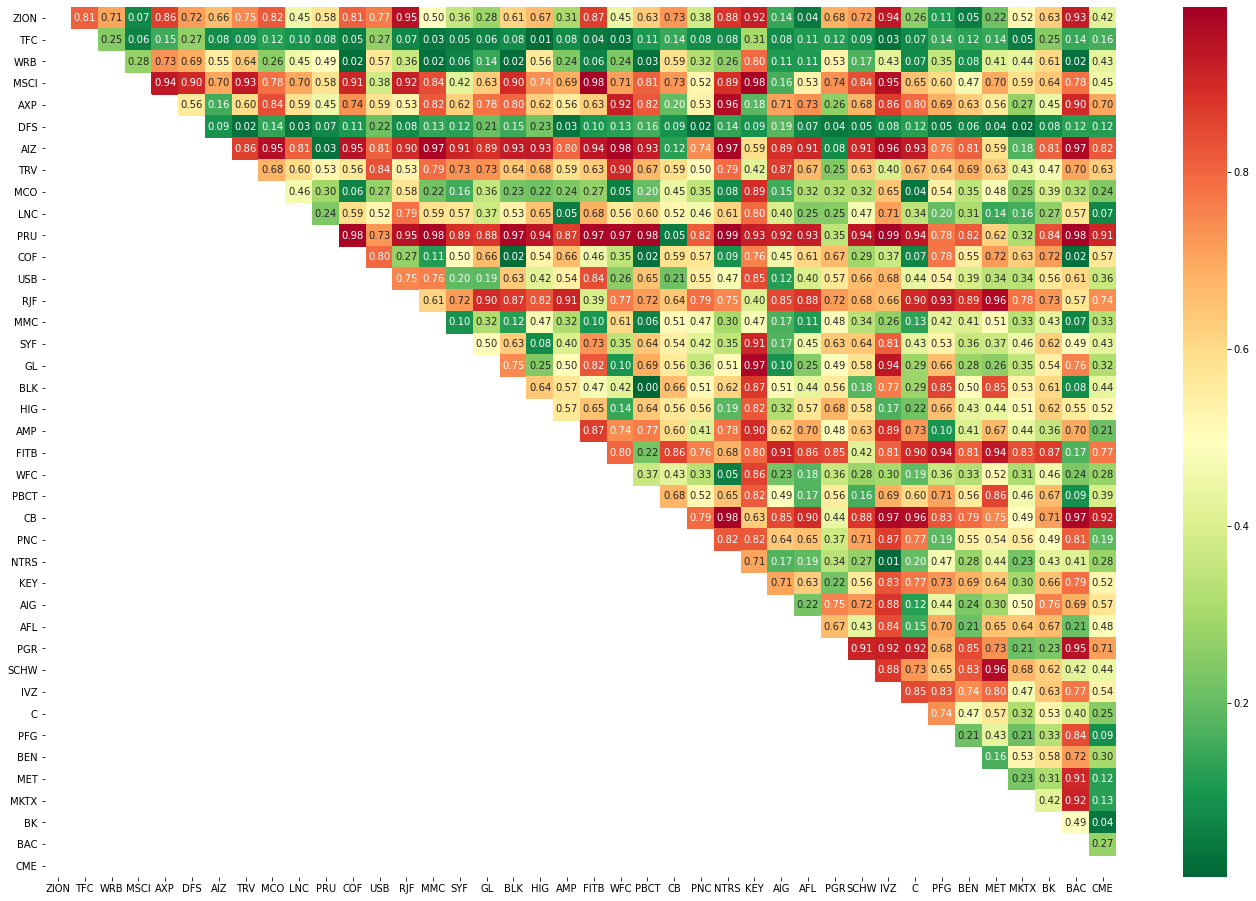

In [89]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(24,16))
sns.heatmap(pvalues, xticklabels = symbols,
                yticklabels = symbols, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99), ax=ax)

## Part II - Hedge Ratio and Spread Calculation

Our strategy has taken into account the stationarity of the time series considering the variable mean and variance to be constant and no presence of unit root. Stationarity of the spread is an important determinant of pairs trading. Here, we have used an auto regressive model of order 1 which requires time series to be stationary (mean reversion) in order to avoid spurious regression. Calculating dynamic hedge ratio is the first step for calculating the spread. We have calculated the dynamic hedge ratio using rolling OLS Regression instead of normal OLS Regression. Hedge ratio calculated using normal OLS Regression is the slope of the regression line which remains constant as the ratio of the assets bought/sold changes and is thus not a good measure for the hedge ratio. Therefore, we have calculated the dynamic hedge ratio which takes into account the changing strength of cointegration over time and gives a better analysis of the portfolio. Rolling Regression also helps to overcome the look ahead bias which might lead to overconfidence in the strategy and skewed results at the end as the data that was not readily available at the time is used in the simulation at that time and thus giving a chance to predict and mitigate future events. Then, once we have the dynamic hedge ratio, we have calculated the spread. Spread is mean reverting and to check the stationarity of the spread, we have used the Augmented Dickey Fuller Test.



In [90]:
data = pd.DataFrame()
asset_1, asset_2 = ("COF", "CFG")

data[asset_1] = df[asset_1]
data[asset_2] = df[asset_2]

model=sm.OLS(df[asset_1], df[asset_2]).fit()

rolling_beta = RollingOLS(endog=df[asset_1], exog=df[asset_2], window=30).fit()
spread = df[asset_2] - rolling_beta.params[asset_2] * df[asset_1]
spread = spread.dropna()

# Run Augmented dickey fuller test to calc critical value
adf = adfuller(spread, maxlag = 1)

Text(0, 0.5, 'Value')

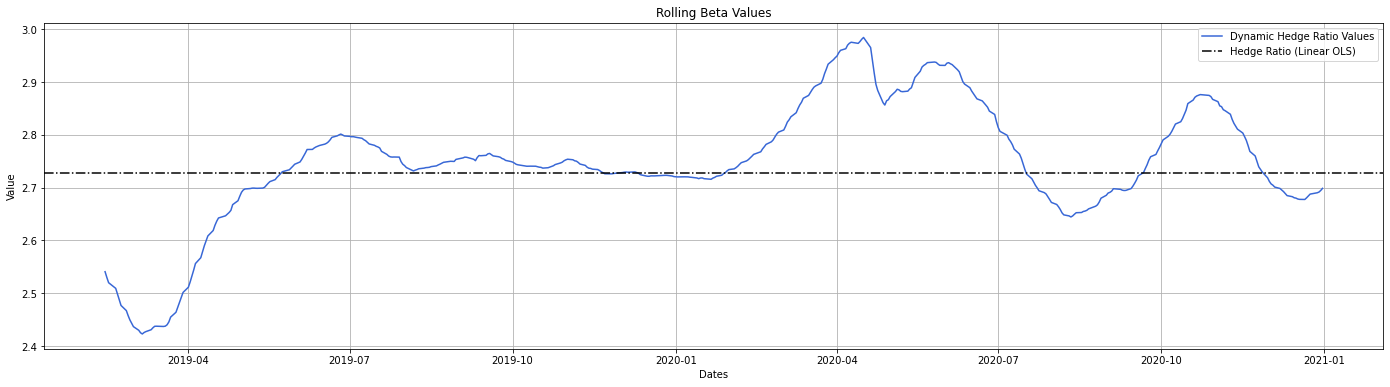

In [91]:
fig, ax=plt.subplots(figsize=(24,6))
ax.plot(rolling_beta.params[asset_2], color="#3867d6", label="Dynamic Hedge Ratio Values")
ax.axhline(model.params[0], color="black", linestyle="-.", label="Hedge Ratio (Linear OLS)")
ax.grid(True)
ax.legend()
ax.set_title("Rolling Beta Values")
ax.set_xlabel("Dates")
ax.set_ylabel("Value")

The above depicted graph has compared the two methods to calculate hedge ratio- linear OLS Regression and Rolling Regression. Hedge ratio (black curve) derived from slope of the linear regression curve remains constant and thus the ratio of the two securities bought/sold are invariable whereas the dynamic hedge ratio (blue curve) calculated using rolling regression takes into account the changing strength of cointegration over time. Therefore, Rolling Regression is a better assessment of hedge ratio as an evolving function of time.

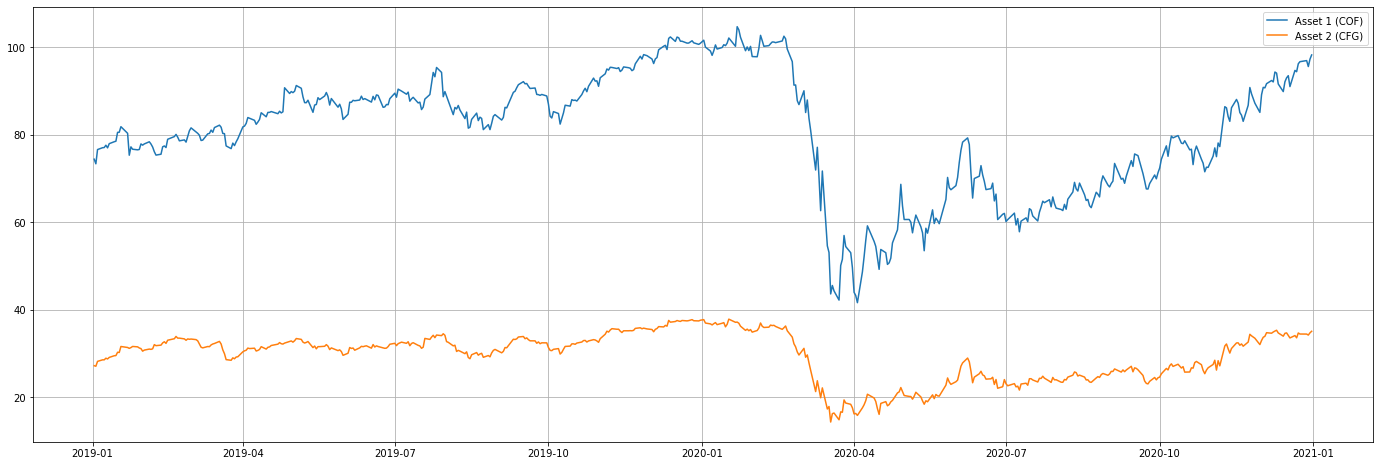

In [92]:
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(df[asset_1])
ax.plot(df[asset_2])
ax.legend([f'Asset 1 ({asset_1})', f'Asset 2 ({asset_2})'])
ax.grid(True)

The above graph is a visual representation of the closing price of the two securities in the past one year. 

Text(0.5, 0, 'Date')

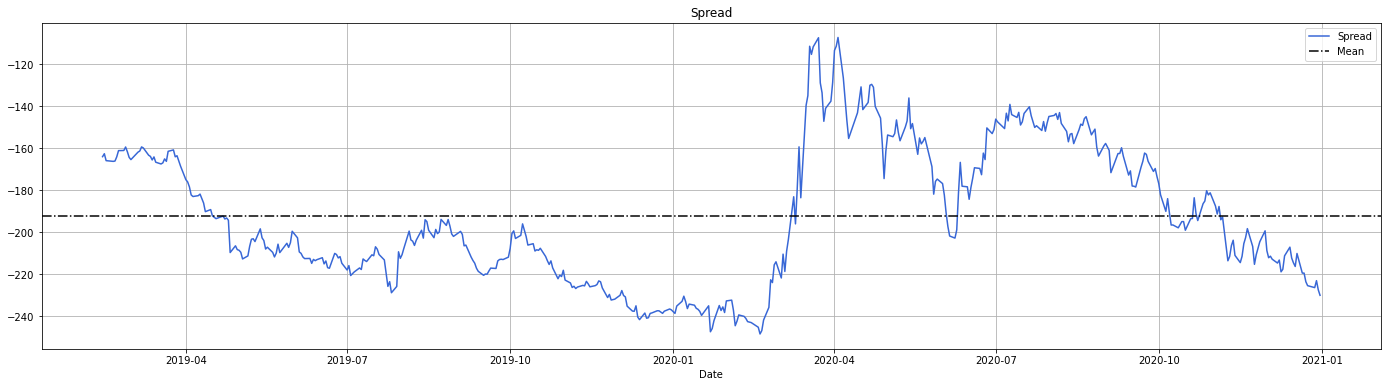

In [93]:
fig, ax = plt.subplots(figsize=(24,6))
ax.plot(spread, label="Spread", color="#3867d6")
ax.set_title("Spread")
ax.axhline(spread.mean(), color='black', linestyle='-.', label="Mean")
ax.legend()
ax.grid(True)
ax.set_xlabel("Date")

Text(0.5, 0, 'Date')

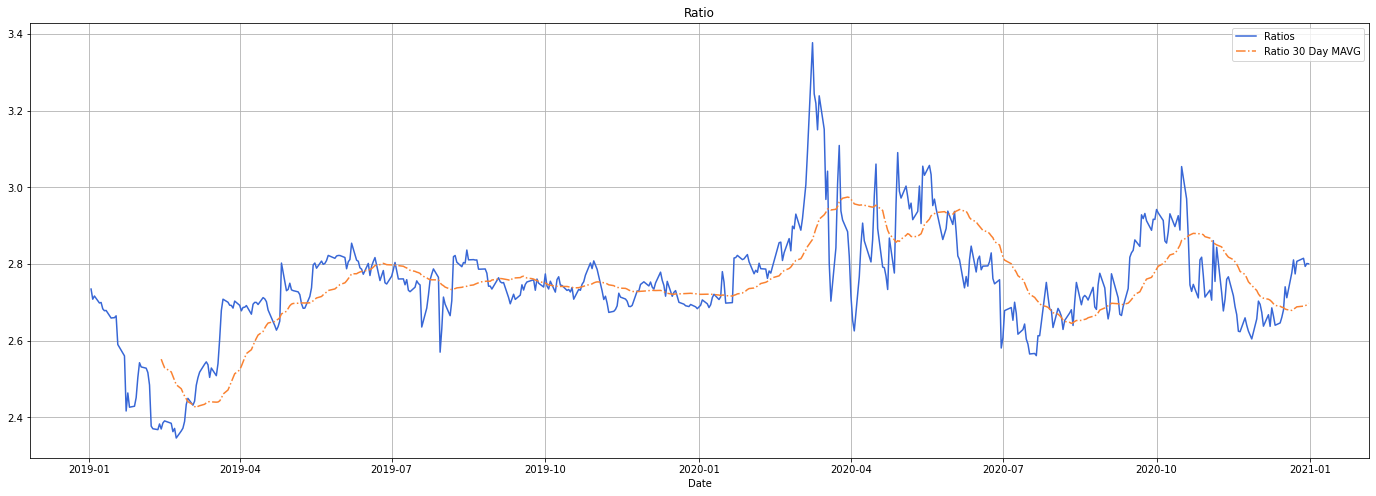

In [94]:
signals = pd.DataFrame() 
signals[asset_1] = data[asset_1]
signals[asset_2] = data[asset_2]

ratios = signals[asset_1]/signals[asset_2]
ratios_mavg30 = ratios.rolling(30).mean()

fig, ax = plt.subplots(figsize=(24,8))

ax.plot(ratios, label="Ratios", color="#3867d6")
ax.plot(ratios_mavg30, label="Ratio 30 Day MAVG", color="#fa8231", linestyle="-.")
ax.grid(True)
ax.legend()
ax.set_title("Ratio")
ax.set_xlabel("Date")

The given graph presents the ratio of the closing price of the two securities through the blue curve. The orange curve represents the 30 day moving average of the ratio of the prices of the securities. 

## Part III - Generate Trading Signals

Next, we have utilized test data sets to generate trading signals. In order to generate trading signals, we have calculated the z-scores using the ratio of the closing price of the two securities. Ratios are a better measure for z-score compared to spread as spread is more volatile. While calculating z-score, we have taken rolling mean and variance to overcome the look ahead bias. Once we have our z-scores, we have devised our strategy using Bollinger Bands,which tells how far a price is from population mean value. Bollinger Bands is a popular technique analyzed by a pair of lines, denoted as upper and lower band, plotted two standard deviations away from the simple moving average. If the prices move closer to the upper band, investors are suggested to take a short position in their portfolio and conversely, if they tend to move closer to the lower band, investors should take a long position. In order to hedge profit, we infer the situations where prices move in the other direction. The expectation is that prices will revert back to mean or to 0, and investors can Take Profit scenarios when the moving average crosses zero for the first time after reverting from the bands.

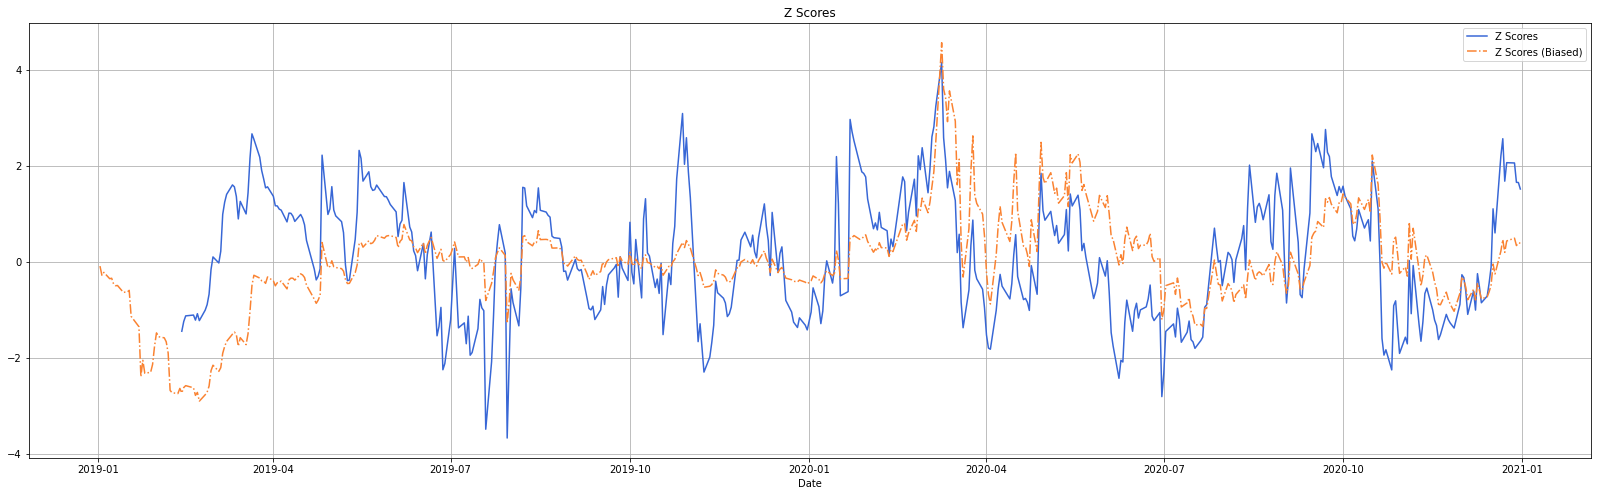

In [95]:
# Calculate the zscore for the series 
signals['z'] = (ratios-ratios_mavg30)/ratios.rolling(30).std()
signals['z_biased'] = (ratios - ratios.mean())/ratios.std()

upper_limit = signals['z'].rolling(20).mean() + signals['z'].rolling(20).std()*2
lower_limit = signals['z'].rolling(20).mean() - signals['z'].rolling(20).std()*2


signals['signals1'] = np.select([signals['z'] > upper_limit, signals['z'] < lower_limit], [-1, 1])
signals["positions1"] = signals["signals1"].diff()
signals["signals2"] = -signals["signals1"]
signals["positions2"] = signals["signals2"].diff()

signals["dates"] = signals.index

short_positions_2 = signals[signals["positions1"] == -1]["dates"]
long_positions_2 = signals[signals["positions1"] == 1]["dates"]

short_positions_1 = signals[signals["positions2"] == -1]["dates"]
long_positions_1 = signals[signals["positions2"] == 1]["dates"]

data["Date"] = data.index

short_points_1 = data[data["Date"].isin(short_positions_1)]
long_points_1 = data[data["Date"].isin(long_positions_1)]

short_points_2 = data[data["Date"].isin(short_positions_2)]
long_points_2 = data[data["Date"].isin(long_positions_2)]


fig, ax = plt.subplots(figsize=(28,8))
ax.plot(signals['z'], label="Z Scores", color="#3867d6")
ax.plot(signals['z_biased'], label="Z Scores (Biased)", color="#fa8231", linestyle="-.")

ax.set_title('Z Scores')
ax.set_xlabel("Date")

ax.legend()
ax.grid(True)

Text(0, 0.5, 'Price')

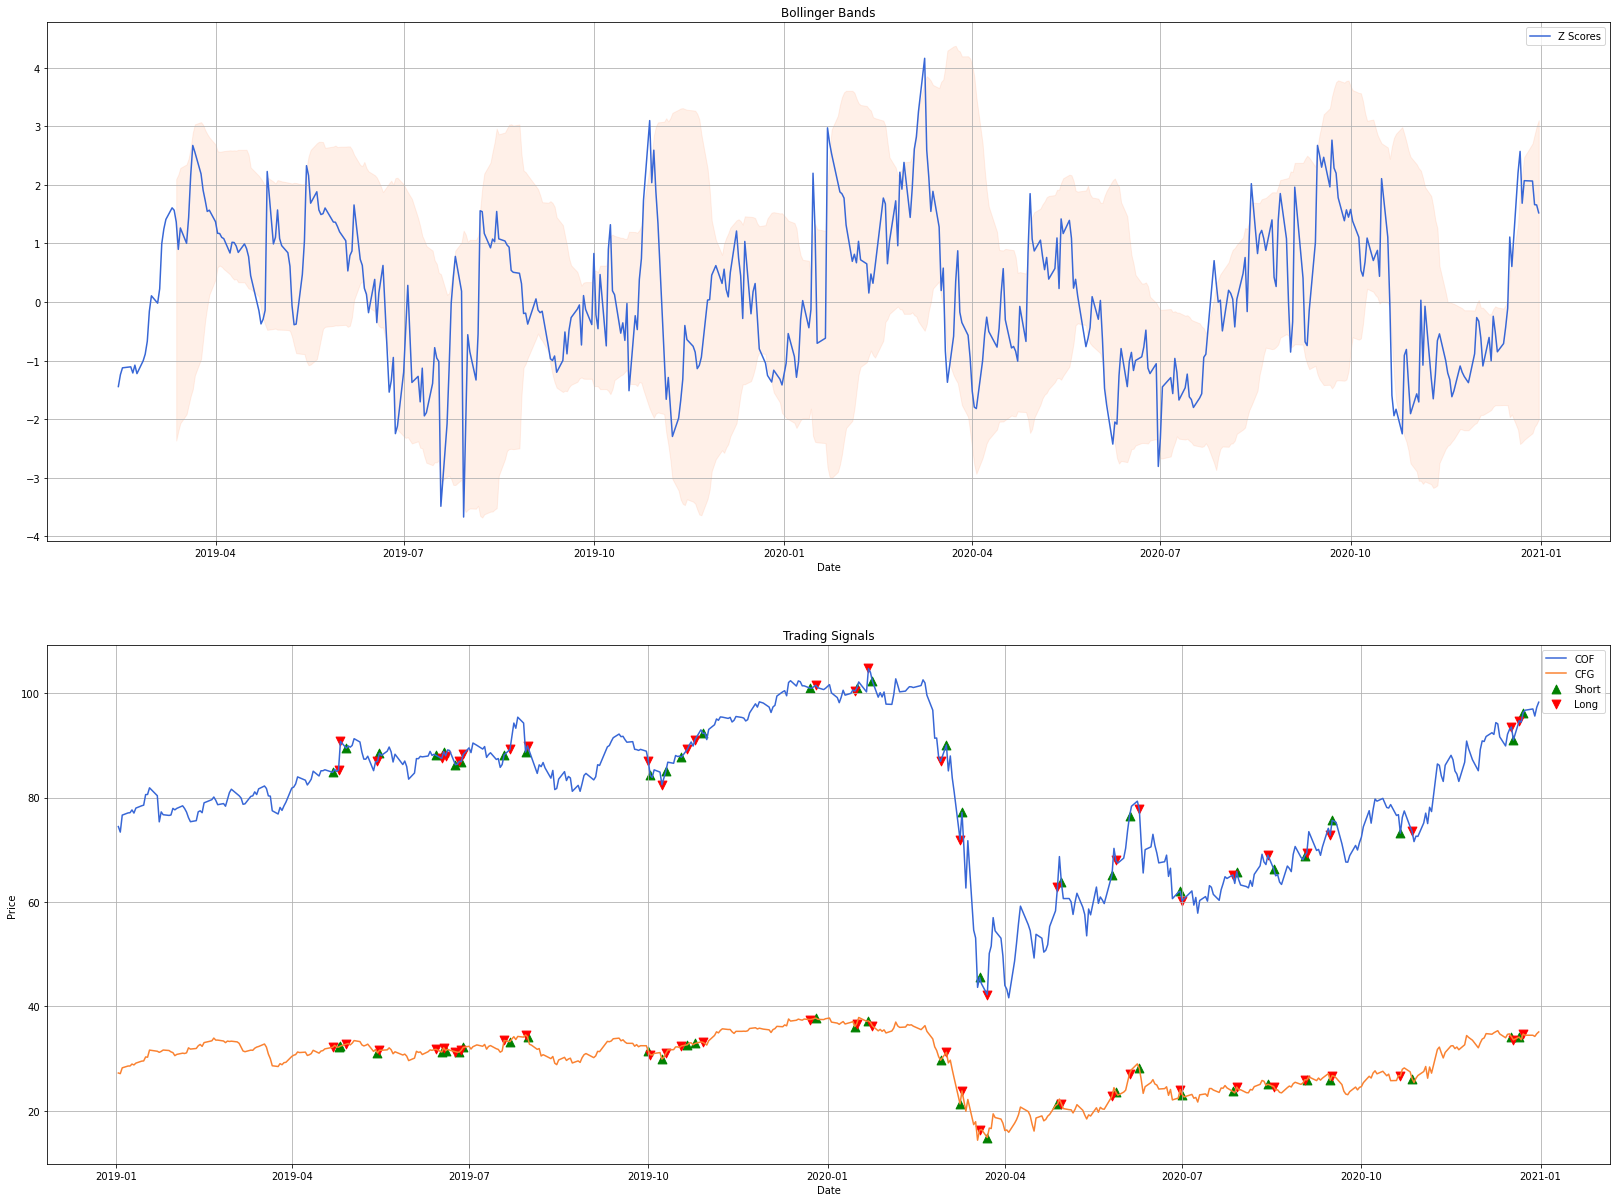

In [96]:
fig, axs = plt.subplots(2, figsize=(28,21))

z_mvg20 = signals['z'].rolling(20).mean()

axs[0].plot(signals['z'], label="Z Scores", color="#3867d6")
axs[0].fill_between(ratios.index, upper_limit, lower_limit, alpha=0.2,color='#ffb48f')
axs[0].set_title('Bollinger Bands')
axs[0].set_xlabel("Date")

axs[0].legend()
axs[0].grid(True)

marker_size = 78

axs[1].scatter(short_points_1["Date"], short_points_1[asset_1], marker='^', color='g', s=marker_size, label="Short")
axs[1].scatter(long_points_1["Date"], long_points_1[asset_1], marker='v', color='r', s=marker_size, label="Long")
axs[1].scatter(short_points_2["Date"], short_points_2[asset_2], marker='^', color='g', s=marker_size)
axs[1].scatter(long_points_2["Date"], long_points_2[asset_2], marker='v', color='r', s=marker_size)

axs[1].plot(data[asset_1], color="#3867d6", label=asset_1)
axs[1].plot(data[asset_2], color="#fa8231", label=asset_2)

axs[1].grid(True)
axs[1].legend()
axs[1].set_title("Trading Signals")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Price")

In the given graph, we have analysed the generated trading signals using the pairs trading strategy. In our example, when the z-score of COF was touching the upper band, the stock price hiked and touched $82, investors went short on COF and long on CFG


(Take example of March 2020, z score goes above the upperband, we take a short position, by going short on CFG and going long on COF. Calculate the total P&L on both the assets and show that we made a profit. Take example of 2020-06 similarly, and show that we made a loss)

## Part 4 - Backtesting

To check if our strategy works or not we calculate the daily returns, annualized volatility, Sharpe ratio and Compound Annual Growth Rate. Since it is a market neutral strategy we go long and short simultaneously with the same capital. Here we have taken $100,000 as the initial capital and calculate the number of shares for each of the Assets. We then calculate the CAGR and Sharpe Ratio. We have calculated Sharpe Ratio to get a better idea of the performance of the pair as it helps us understand the return of the investment compared to its risk. To calculate sharpe ratio we tend to know the volatility of the investment in annual terms and therefore we have calculated annualized volatility. Similarly, CAGR diminishes the effect of volatility of periodic returns and calculates the annual growth of investment taking into account the effect of compounding. In our example, we have an annualized volatility of 2.66%, Sharpe ratio of 2.468 and a CAGR of 6.75%. 


CAGR = 6.75%
Annualized Volatility = 2.66%
Sharpe Ratio = 2.468
-1.7553838242122977


Text(0, 0.5, 'Value')

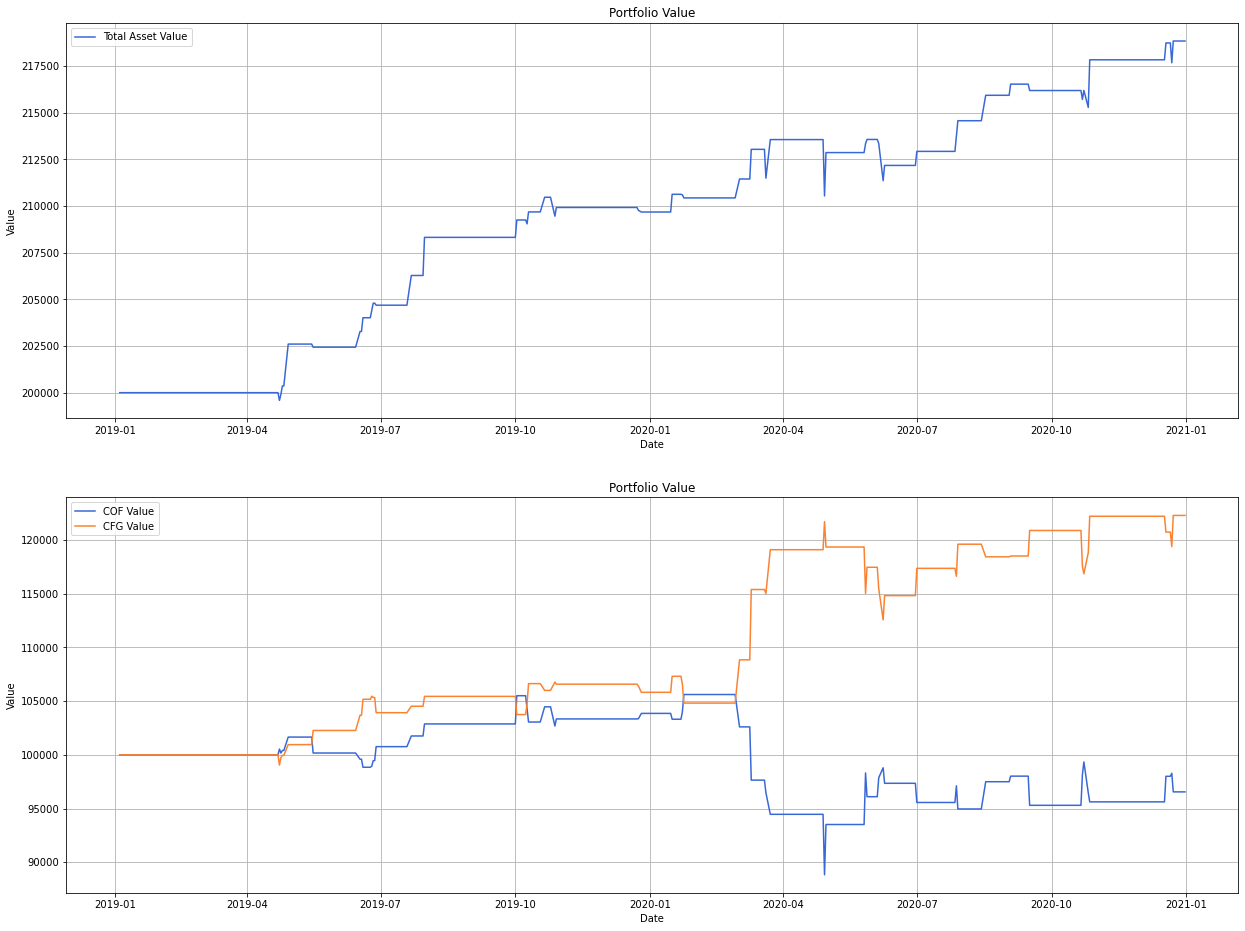

In [97]:
# Initial capital
initial_capital = 100000

asset_1_shares = initial_capital // max(data[asset_1])
asset_2_shares = initial_capital // max(data[asset_2])

portfolio = pd.DataFrame()
portfolio["Asset 1"] = data[asset_1]
portfolio["holdings1"] = signals["positions1"].cumsum() * data[asset_1] * asset_1_shares
portfolio["cash1"] = initial_capital - (signals["positions1"] * data[asset_1] * asset_1_shares).cumsum()
portfolio["total1"] = portfolio["holdings1"] + portfolio["cash1"]
portfolio["return1"] = portfolio["total1"].pct_change()

portfolio["Asset 2"] = data[asset_2]
portfolio["holdings2"] = signals["positions2"].cumsum() * data[asset_2] * asset_2_shares
portfolio["cash2"] = initial_capital - (signals["positions2"] * data[asset_2] * asset_2_shares).cumsum()
portfolio["total2"] = portfolio["holdings2"] + portfolio["cash2"]
portfolio["return2"] = portfolio["total2"].pct_change()
portfolio = portfolio.dropna()
portfolio["total_assets"] = portfolio["total1"] + portfolio["total2"]

total_asset_value = list(portfolio["total_assets"])
beginning_value=total_asset_value[0]
final_value= total_asset_value[-1]
years= len(total_asset_value)/365
CAGR= (final_value/beginning_value)**(1/years)-1

daily_returns = portfolio["total_assets"].pct_change()
daily_returns = daily_returns.dropna()

annualized_volatility = daily_returns.std()*(252)**(1/2)
sharpe_ratio = (CAGR-0.002)/(annualized_volatility)

print(f'CAGR = {CAGR*100:.2f}%')
print(f'Annualized Volatility = {annualized_volatility*100:.2f}%')
print(f'Sharpe Ratio = {sharpe_ratio:.3f}')
print(adf[0])
    
    
fig, axs = plt.subplots(2, figsize=(21,16))
axs[0].plot(portfolio["total_assets"], color="#3867d6", label="Total Asset Value")
axs[0].grid(True)
axs[0].legend()
axs[0].set_title("Portfolio Value")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Value")

axs[1].plot(portfolio["total1"], color="#3867d6", label=f"{asset_1} Value")
axs[1].plot(portfolio["total2"], color="#fa8231", label=f"{asset_2} Value")
axs[1].grid(True)
axs[1].legend()
axs[1].set_title("Portfolio Value")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Value")

# Conclusion

We can conclude that our strategy on pairs trading is successful as the investors earns a profit and is more risk free.